In [25]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [26]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [27]:
files = os.listdir(path)

In [28]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [29]:
images = [kb.layered_image(f) for f in files]

Object Generation Parameters

In [30]:
p = kb.psf(1.5)
object_count = 10
x_range = (5,3650)
y_range = (5, 3650)
angle_range = (0.1, 0.5)
velocity_range = (1900, 2900)
flux_range = (800, 4000)

Search Parameters

In [31]:
min_observations = 3
angle_steps = 200
velocity_steps = 180
search_margin = 1.2

In [32]:
print(angle_range[1]-angle_range[0])
print(velocity_range[1]-velocity_range[0])

0.4
1000


Generate Random trajectories within bounds

In [33]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    ang = rd.uniform(*angle_range)
    vel = rd.uniform(*velocity_range)
    traj.x_v = vel*math.cos(ang)
    traj.y_v = vel*math.sin(ang)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

Add a real object to the list of trajectories

In [34]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3123
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key

[lh: 0.000000 flux: 1932.882080 x: 2684 y: 1471 x_v: 2460.249268 y_v: 390.659821 obs_count: 0,
 lh: 0.000000 flux: 1477.059326 x: 3408 y: 1445 x_v: 1999.727417 y_v: 859.020081 obs_count: 0,
 lh: 0.000000 flux: 963.969727 x: 716 y: 1555 x_v: 2205.377197 y_v: 637.980835 obs_count: 0,
 lh: 0.000000 flux: 2383.808838 x: 930 y: 537 x_v: 2795.468262 y_v: 521.910950 obs_count: 0,
 lh: 0.000000 flux: 3742.835693 x: 470 y: 1686 x_v: 2384.556641 y_v: 291.132019 obs_count: 0,
 lh: 0.000000 flux: 1591.464355 x: 2321 y: 2160 x_v: 2518.688965 y_v: 370.651703 obs_count: 0,
 lh: 0.000000 flux: 1592.473145 x: 2677 y: 1926 x_v: 2108.179932 y_v: 311.851868 obs_count: 0,
 lh: 0.000000 flux: 2028.341064 x: 108 y: 739 x_v: 1901.082642 y_v: 742.430603 obs_count: 0,
 lh: 0.000000 flux: 3677.913574 x: 1655 y: 2479 x_v: 2729.368164 y_v: 891.598206 obs_count: 0,
 lh: 0.000000 flux: 2273.040771 x: 2392 y: 3523 x_v: 1970.469238 y_v: 341.792786 obs_count: 0,
 lh: 0.000000 flux: 5300.000000 x: 3123 y: 3043 x_v: 2425

Test that clustering is not able to collapse together too many unique trajectories

In [35]:
len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

11

Use the generated trajectories to add objects into the images

In [36]:
for t in results_key:
    add_trajectory(images, t, p)

Sanity check

In [37]:
len(match_trajectories(results_key, results_key, 0.01, 1)[0])

11

In [38]:
stack = kb.image_stack(images)

Mask out stars and bad pixels

In [39]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [40]:
stack.apply_mask_flags(flags, flag_exceptions)

In [41]:
stack.apply_master_mask(master_flags, 2)

In [42]:
images = [i.science() for i in stack.get_images()]

Calculate masked percentage of an image to estimate probablilty of placing an object under a mask

In [43]:
img = images[1]
percent_masked = img[np.where(img==-9999.99)].size/img.size
percent_masked

0.15934744897959183

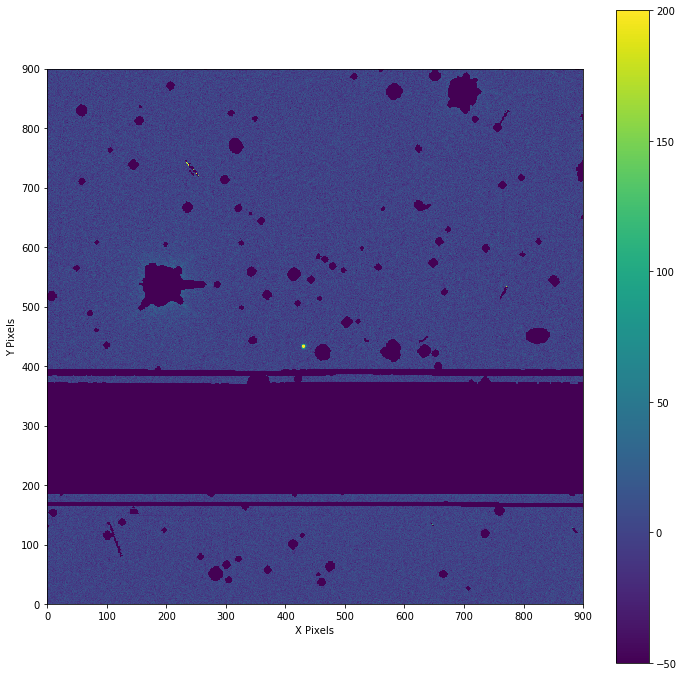

In [44]:
fig = plt.figure(figsize=(12,12))
plt.imshow(images[1] [2700:3600,2900:3800], origin='lower',  vmin=-50, vmax=200)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [49]:
search = kb.stack_search(stack, p)
search.set_debug(True)

In [50]:
search_ang_r = (angle_range[0]/search_margin,
                angle_range[1]*search_margin)
search_vel_r = (velocity_range[0]/search_margin,
                velocity_range[1]*search_margin)
#search.gpu(angle_steps,velocity_steps, *angle_range, *velocity_range, min_observations)

In [51]:
#search.get_results(0,20)

In [52]:
#search.region_search(2400, 1040, 50, 255, 3)
search.region_search(0, 0, 3500, 100, 3)

[ix: 3124.000000 iy: 3043.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 262.363678 flux 9595.437500,
 ix: 470.000000 iy: 1686.000000 fx: 950.000000 fy: 1745.000000 depth: 0 obs_count: 4 lh: 160.655106 flux 3369.565918,
 ix: 1655.000000 iy: 2479.000000 fx: 2204.000000 fy: 2658.000000 depth: 0 obs_count: 4 lh: 158.775558 flux 3343.591064,
 ix: 2088.000000 iy: 4678.000000 fx: 2669.000000 fy: 2534.000000 depth: 0 obs_count: 3 lh: 140.685074 flux 11987.619141,
 ix: 437.000000 iy: 2867.000000 fx: 994.000000 fy: 3206.000000 depth: 0 obs_count: 3 lh: 126.929794 flux 8561.707031,
 ix: 2746.000000 iy: 1935.000000 fx: 2653.000000 fy: 1682.000000 depth: 0 obs_count: 3 lh: 124.127563 flux 8396.350586,
 ix: 28.000000 iy: 1924.000000 fx: 1240.000000 fy: 4165.000000 depth: 0 obs_count: 3 lh: 118.477776 flux 6769.370117,
 ix: 2087.000000 iy: 4939.000000 fx: 2655.000000 fy: 2217.000000 depth: 0 obs_count: 3 lh: 116.984291 flux 7519.216309,
 ix: 4644.000000 iy: 53.000000 fx: 2669.00000